In [1]:
from causalinference import CausalModel

In [2]:
from causalinference.utils import random_data

In [3]:
Y, D, X = random_data()

In [4]:
Y

array([ 2.91151058,  7.39804622,  1.38896718, ...,  0.43313153,
       -2.74486327, -2.19476756])

In [17]:
import matplotlib.pyplot as plt

(array([2466.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2534.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

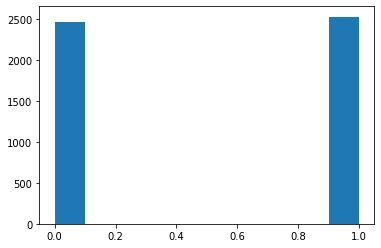

In [18]:
plt.hist(D)

In [38]:
model = CausalModel(Y, D, X)

TypeError: __init__() missing 1 required positional argument: 'Y'

In [15]:
help(model.est_propensity)

Help on method est_propensity in module causalinference.causal:

est_propensity(lin='all', qua=None) method of causalinference.causal.CausalModel instance
    Estimates the propensity scores given list of covariates to
    include linearly or quadratically.
    
    The propensity score is the conditional probability of
    receiving the treatment given the observed covariates.
    Estimation is done via a logistic regression.
    
    Parameters
    ----------
    lin: string or list, optional
            Column numbers (zero-based) of variables of
            the original covariate matrix X to include
            linearly. Defaults to the string 'all', which
            uses whole covariate matrix.
    qua: list, optional
            Tuples indicating which columns of the original
            covariate matrix to multiply and include. E.g.,
            [(1,1), (2,3)] indicates squaring the 2nd column
            and including the product of the 3rd and 4th
            columns. Default

In [6]:
model.est_propensity()

In [10]:
pro_scores = model.propensity['fitted']

In [12]:
print(pro_scores)

[0.31965519 0.96837186 0.44464778 ... 0.67462988 0.16543586 0.06414834]


# Computing Pro Scores via logistic regression

In [13]:
import statsmodels.formula.api as smf


In [19]:
help(smf.logit)

Help on method from_formula in module statsmodels.base.model:

from_formula(formula, data, subset=None, drop_cols=None, *args, **kwargs) method of builtins.type instance
    Create a Model from a formula and dataframe.
    
    Parameters
    ----------
    formula : str or generic Formula object
        The formula specifying the model.
    data : array_like
        The data for the model. See Notes.
    subset : array_like
        An array-like object of booleans, integers, or index values that
        indicate the subset of df to use in the model. Assumes df is a
        `pandas.DataFrame`.
    drop_cols : array_like
        Columns to drop from the design matrix.  Cannot be used to
        drop terms involving categoricals.
    *args
        Additional positional argument that are passed to the model.
    **kwargs
        These are passed to the model with one exception. The
        ``eval_env`` keyword is passed to patsy. It can be either a
        :class:`patsy:patsy.EvalEnvironm

In [21]:
import pandas as pd

In [26]:
X.shape

(5000, 3)

In [28]:
## dataframe for smf
causal_df = pd.DataFrame({'D':D, 'X1':X[:,0], 'X2':X[:, 1], 'X3':X[:, 2]})
causal_df.head()

,D,X1,X2,X3
0,1,-0.173208,-0.146131,-0.463690
1,1,-0.285450,1.718771,2.014767
2,1,-0.111231,-0.338644,0.201513
3,0,-0.222078,-1.155089,-0.347328
4,0,0.285717,-0.048646,-1.151709


In [30]:
logistic_model = smf.logit(formula="D ~ X1 + X2 + X3", data=causal_df).fit()

Optimization terminated successfully.
         Current function value: 0.500995
         Iterations 6


In [31]:
logistic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      D   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4996
Method:                           MLE   Df Model:                            3
Date:                Sun, 30 Oct 2022   Pseudo R-squ.:                  0.2771
Time:                        12:26:37   Log-Likelihood:                -2505.0
converged:                       True   LL-Null:                       -3465.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0147      0.035      0.423      0.672      -0.053       0.083
X1             0.9603      0.041     23.608      0.000       0.881       1.040
X2             0.9761      0.041     23.806      0.000       0.896       1.056
X3             0.9943      0.041     24.433      0.000       0.915       1.074
==============================================================================
"""

In [32]:
pro_scores

array([0.31965519, 0.96837186, 0.44464778, ..., 0.67462988, 0.16543586,
       0.06414834])

In [33]:
model.propensity

{'lin': range(0, 3), 'qua': [], 'coef': array([0.01467386, 0.96031512, 0.97609148, 0.99432781]), 'loglike': -2504.97704136334, 'fitted': array([0.31965519, 0.96837186, 0.44464778, ..., 0.67462988, 0.16543586,
       0.06414834]), 'se': array([0.03468387, 0.04067722, 0.04100248, 0.04069583])}

## Seems like the coefficients do match

In [36]:
predicted_values = logistic_model.predict(causal_df[['X1', 'X2', 'X3']])

In [37]:
predicted_values

0       0.319655
1       0.968372
2       0.444648
3       0.158235
4       0.288310
          ...   
4995    0.872487
4996    0.089933
4997    0.674630
4998    0.165436
4999    0.064148
Length: 5000, dtype: float64

## Seems like the pro_scores are also a match

# Matching

The units can be matched based on the `propensity scores` 

In [40]:
import seaborn as sns

In [41]:
df_pro_d = pd.DataFrame({'D':D, 'pro_scores':pro_scores})

In [48]:
help(sns.kdeplot)

Help on function kdeplot in module seaborn.distributions:

kdeplot(x=None, *, y=None, shade=None, vertical=False, kernel=None, bw=None, gridsize=200, cut=3, clip=None, legend=True, cumulative=False, shade_lowest=None, cbar=False, cbar_ax=None, cbar_kws=None, ax=None, weights=None, hue=None, palette=None, hue_order=None, hue_norm=None, multiple='layer', common_norm=True, common_grid=False, levels=10, thresh=0.05, bw_method='scott', bw_adjust=1, log_scale=None, color=None, fill=None, data=None, data2=None, warn_singular=True, **kwargs)
    Plot univariate or bivariate distributions using kernel density estimation.
    
    A kernel density estimate (KDE) plot is a method for visualizing the
    distribution of observations in a dataset, analagous to a histogram. KDE
    represents the data using a continuous probability density curve in one or
    more dimensions.
    
    The approach is explained further in the :ref:`user guide <tutorial_kde>`.
    
    Relative to a histogram, KDE can

<AxesSubplot:xlabel='pro_scores', ylabel='Density'>

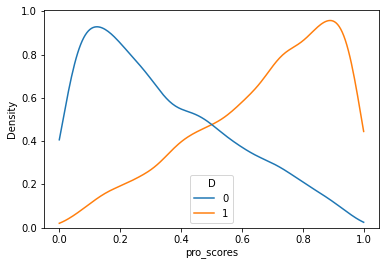

In [50]:
sns.kdeplot(df_pro_d['pro_scores'], hue=df_pro_d['D'], clip=(0.0, 1.0))

## Trim those obs below 0.1 and 0.9

In [51]:
causal_df['pro_scores'] = pro_scores

In [52]:
causal_df.head()

,D,X1,X2,X3,pro_scores
0,1,-0.173208,-0.146131,-0.463690,0.319655
1,1,-0.285450,1.718771,2.014767,0.968372
2,1,-0.111231,-0.338644,0.201513,0.444648
3,0,-0.222078,-1.155089,-0.347328,0.158235
4,0,0.285717,-0.048646,-1.151709,0.288310


In [54]:
causal_df_trimmed = causal_df[(causal_df.pro_scores >= 0.1) & (causal_df.pro_scores<=0.9)]

In [57]:
causal_df_trimmed.shape

(4041, 5)

In [58]:
model.cutoff

0.1

In [60]:
model.trim()

In [62]:
model.raw_data['D'].shape

(4041,)

# Matches with the manual transformation
Both have 4041 obs

In [73]:
model.reset()

In [76]:
model.raw_data['D'].shape

(5000,)

In [79]:
model.est_propensity()

In [82]:
model.trim_s()

In [83]:
model.cutoff

0.09916709145163372

This cutoff should ideally be the min pro score for the control group and (1-max(proscore)) of the treated group

In [90]:
min(causal_df.pro_scores[causal_df.D==0]), min(causal_df.pro_scores[causal_df.D==1])

(0.002281153034871663, 0.01911310112758386)

In [89]:
max(causal_df.pro_scores[causal_df.D==1])

0.9979940067402522

In [84]:
model.raw_data['D'].shape

(4051,)

In [69]:
model2.trim()

In [70]:
model2.raw_data['D'].shape

(4041,)

In [71]:
model2.cutoff

0

In [68]:
model2.old_data['D'].shape

(5000,)